In [288]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML
import xarray
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, population_2020_aggregated, aod_vis_concatenated as aod_members
import xesmf as xe
import numpy as np

def bilinear_interpolation(data_to_interpolate: xarray.DataArray, data_to_match: xarray.DataArray) -> xarray.DataArray:
    regridder = xe.Regridder(data_to_interpolate, data_to_match, 'bilinear')
    return regridder(data_to_interpolate)

exp_num = "3136"

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min, xghg_min, xaer_min = tmin()
all_ds = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1930, 2020)).where(land_mask>0).mean(dim="member")
aer_ds = all_ds - xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1930, 2020)).where(land_mask>0).mean(dim="member")
pop_ds = xarray.open_dataset("/projects/dgs/persad_research/heat_research/data/population/population_histsoc_30arcmin_annual_1901_2020.nc", decode_times=False)["popc"].sel(time=slice(29, 119))


aer_ds = aer_ds.assign_coords(lon=(((aer_ds.lon + 180) % 360) - 180)).sortby('lon').load()
aer_data = aer_ds.sel(time=slice(aer_ds.time.min(), aer_ds.time.min() + pop_ds.time.max()))
land_mask = land_mask.assign_coords(lon=(((land_mask.lon + 180) % 360) - 180)).sortby('lon').load()

# AOD
aod_data = xarray.open_mfdataset(aod_members(), concat_dim="member", combine="nested").mean(dim="member")
aod_data = aod_data["AODVIS"].groupby("time.year").mean().sel(year=slice(1930, 2020))
aod_data = aod_data.assign_coords(lon=(((aod_data.lon + 180) % 360) - 180)).sortby('lon').load().where(land_mask>0)


lat_delta = (aer_data.lat.values[1] - aer_data.lat.values[0]) / 2
lon_delta = (aer_data.lon.values[1] - aer_data.lon.values[0]) / 2
lats = np.append(aer_data.lat.values - lat_delta, aer_data.lat.values[-1::])
lons = np.append(aer_data.lon.values - lon_delta, aer_data.lon.values[-1::])

pop_data = pop_ds.astype(np.float64).groupby_bins("lat", lats).sum().groupby_bins("lon", lons).sum()
pop_data = pop_data.rename({"lat_bins":"lat", "lon_bins":"lon"}).assign_coords(lat=aer_data.lat, lon=aer_data.lon)
pop_data = pop_data.where(land_mask>0)

static_pop_raw = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load().sel(band=1)
static_pop = static_pop_raw.astype(np.float64).groupby_bins("lat", lats).sum().groupby_bins("lon", lons).sum()
static_pop = static_pop.rename({"lat_bins":"lat", "lon_bins":"lon"}).assign_coords(lat=aer_data.lat, lon=aer_data.lon)
static_pop = static_pop.where(land_mask>0)

/tmp/ipykernel_95131/964326935.py:46: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  static_pop_raw = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load().sel(band=1)


In [294]:
import scipy.stats
import numpy as np


years = aer_data.time.values
perc_aer_vals = aer_data.values * 0
for year_i, year in enumerate(aer_data.time):
    grid = aer_data.sel(time=year).values
    std = np.nanstd(grid)
    mean = np.nanmean(grid)
    perc_aer_vals[year_i] = scipy.stats.norm.sf(abs((grid - mean) / std))
perc_aer = aer_data.copy()
perc_aer.values = perc_aer_vals


years = aod_data.year.values
perc_aod_vals = aod_data.values * 0
for year_i, year in enumerate(aod_data.year):
    grid = aod_data.sel(year=year).values
    std = np.nanstd(grid)
    mean = np.nanmean(grid)
    perc_aod_vals[year_i] = scipy.stats.norm.sf(abs((grid - mean) / std))
perc_aod = aod_data.copy()
perc_aod.values = perc_aod_vals


years = pop_data.time.values
perc_pop_vals = pop_data.values * 0
for year_i, year in enumerate(pop_data.time):
    grid = pop_data.sel(time=year).values
    std = np.nanstd(grid)
    mean = np.nanmean(grid)
    perc_pop_vals[year_i] = scipy.stats.norm.sf(abs((grid - mean) / std))
perc_pop = pop_data.copy()
perc_pop.values = perc_pop_vals

def correlate_to_pop(data):
    yearly_corr = years*0
    for year_i in range(0, years.size):
        a = data.values[year_i].flatten()[~np.isnan(data.values[year_i].flatten())]
        b = perc_pop.values[year_i].flatten()[~np.isnan(perc_pop.values[year_i].flatten())]
        yearly_corr[year_i] = np.corrcoef(a, b)[0][1]

    yearly_corr_static = years*0
    static_pop_flat = static_pop.values.flatten()[~np.isnan(static_pop.values.flatten())]
    for year_i in range(0, years.size):
        a = data.values[year_i].flatten()[~np.isnan(data.values[year_i].flatten())]
        yearly_corr_static[year_i] = np.corrcoef(a, static_pop_flat)[0][1]
    return yearly_corr, yearly_corr_static

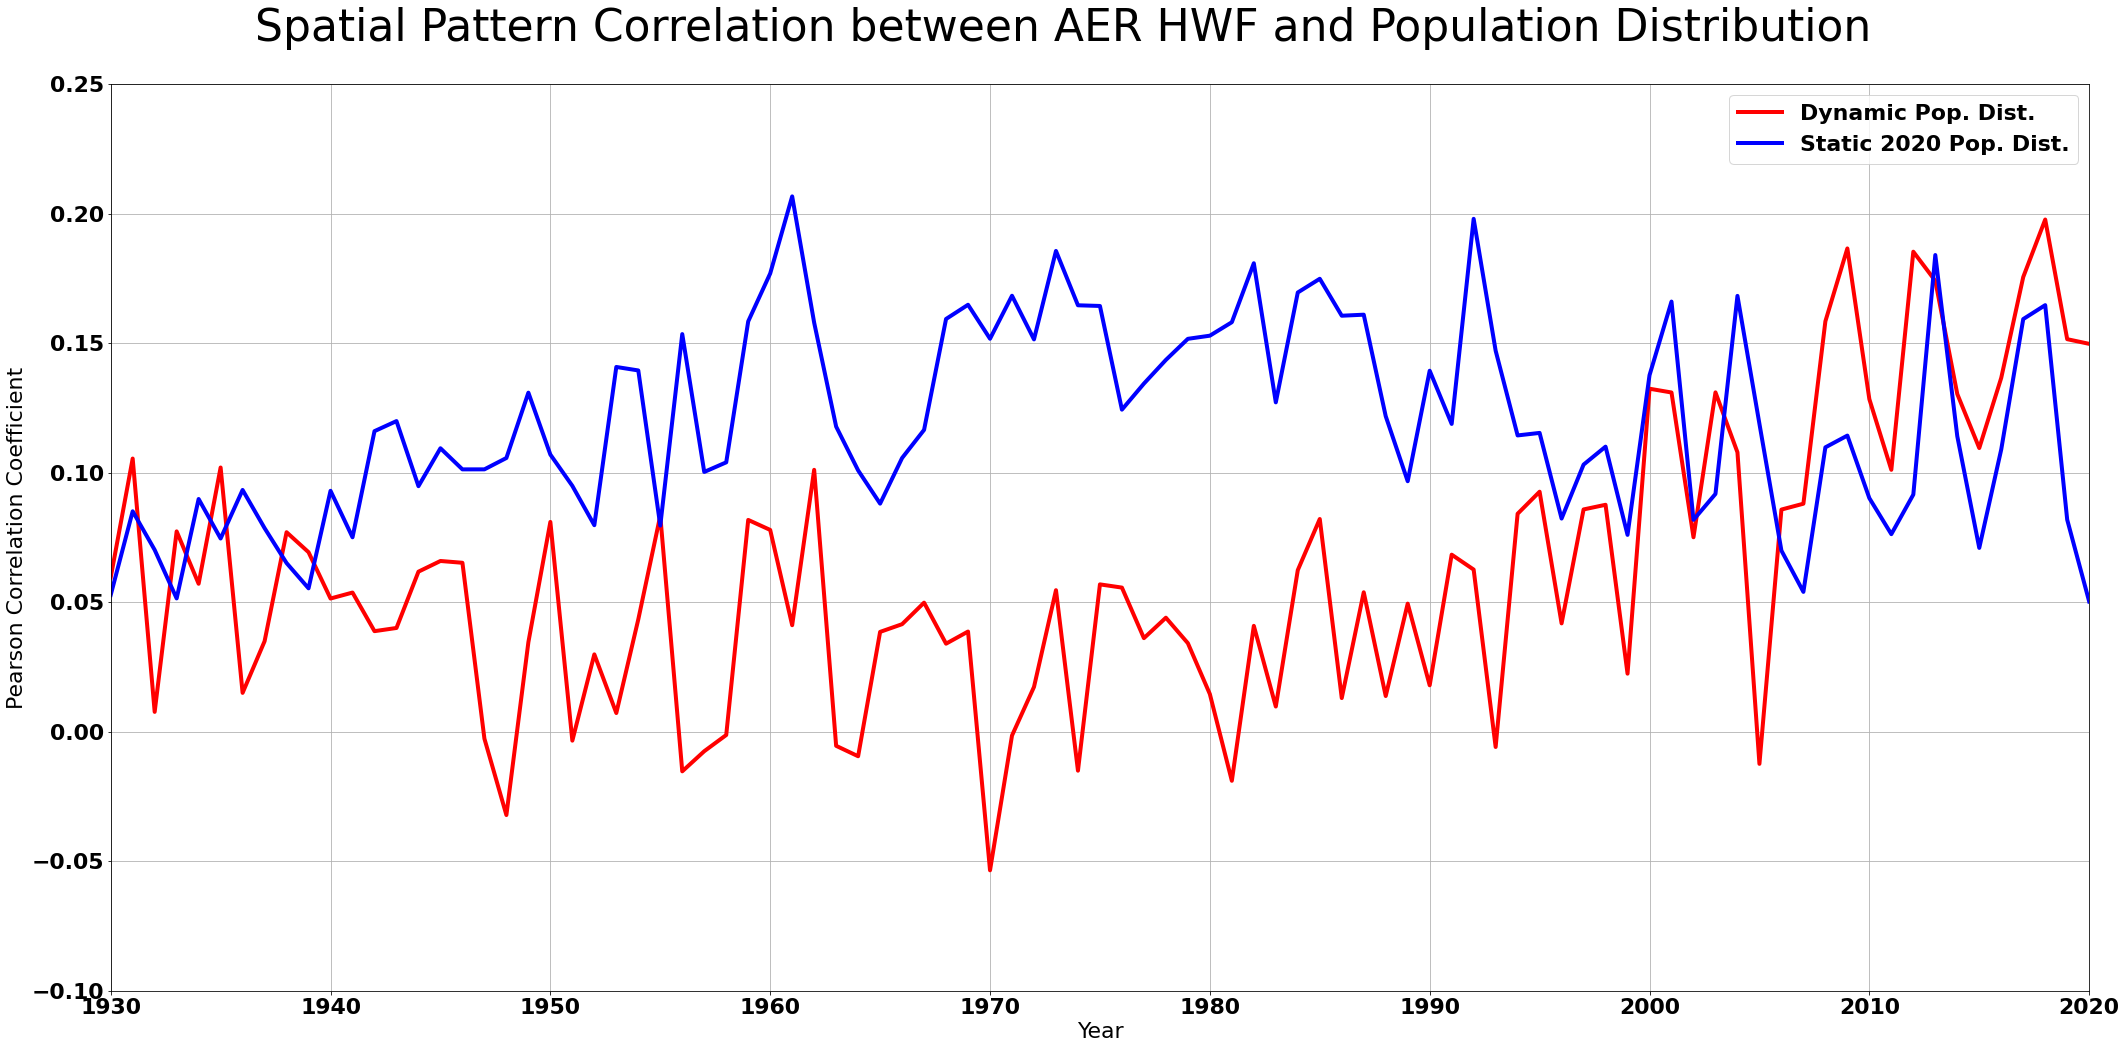

In [296]:
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ax = plt.subplots(1, 1, figsize=(30, 15), facecolor='w')
f.suptitle(f"Spatial Pattern Correlation between AER HWF and Population Distribution", fontsize=44)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

corr, corr_static = correlate_to_pop(perc_aer)
ax.plot(aer_data.time.values, corr, linewidth=4, label="Dynamic Pop. Dist.", color="red")
ax.plot(aer_data.time.values, corr_static, linewidth=4, label="Static 2020 Pop. Dist.", color="blue")
ax.set_xlim(1930, 2020)
ax.set_ylabel("Pearson Correlation Coefficient")
ax.set_xlabel("Year")
ax.grid()
ax.legend()
f.tight_layout()

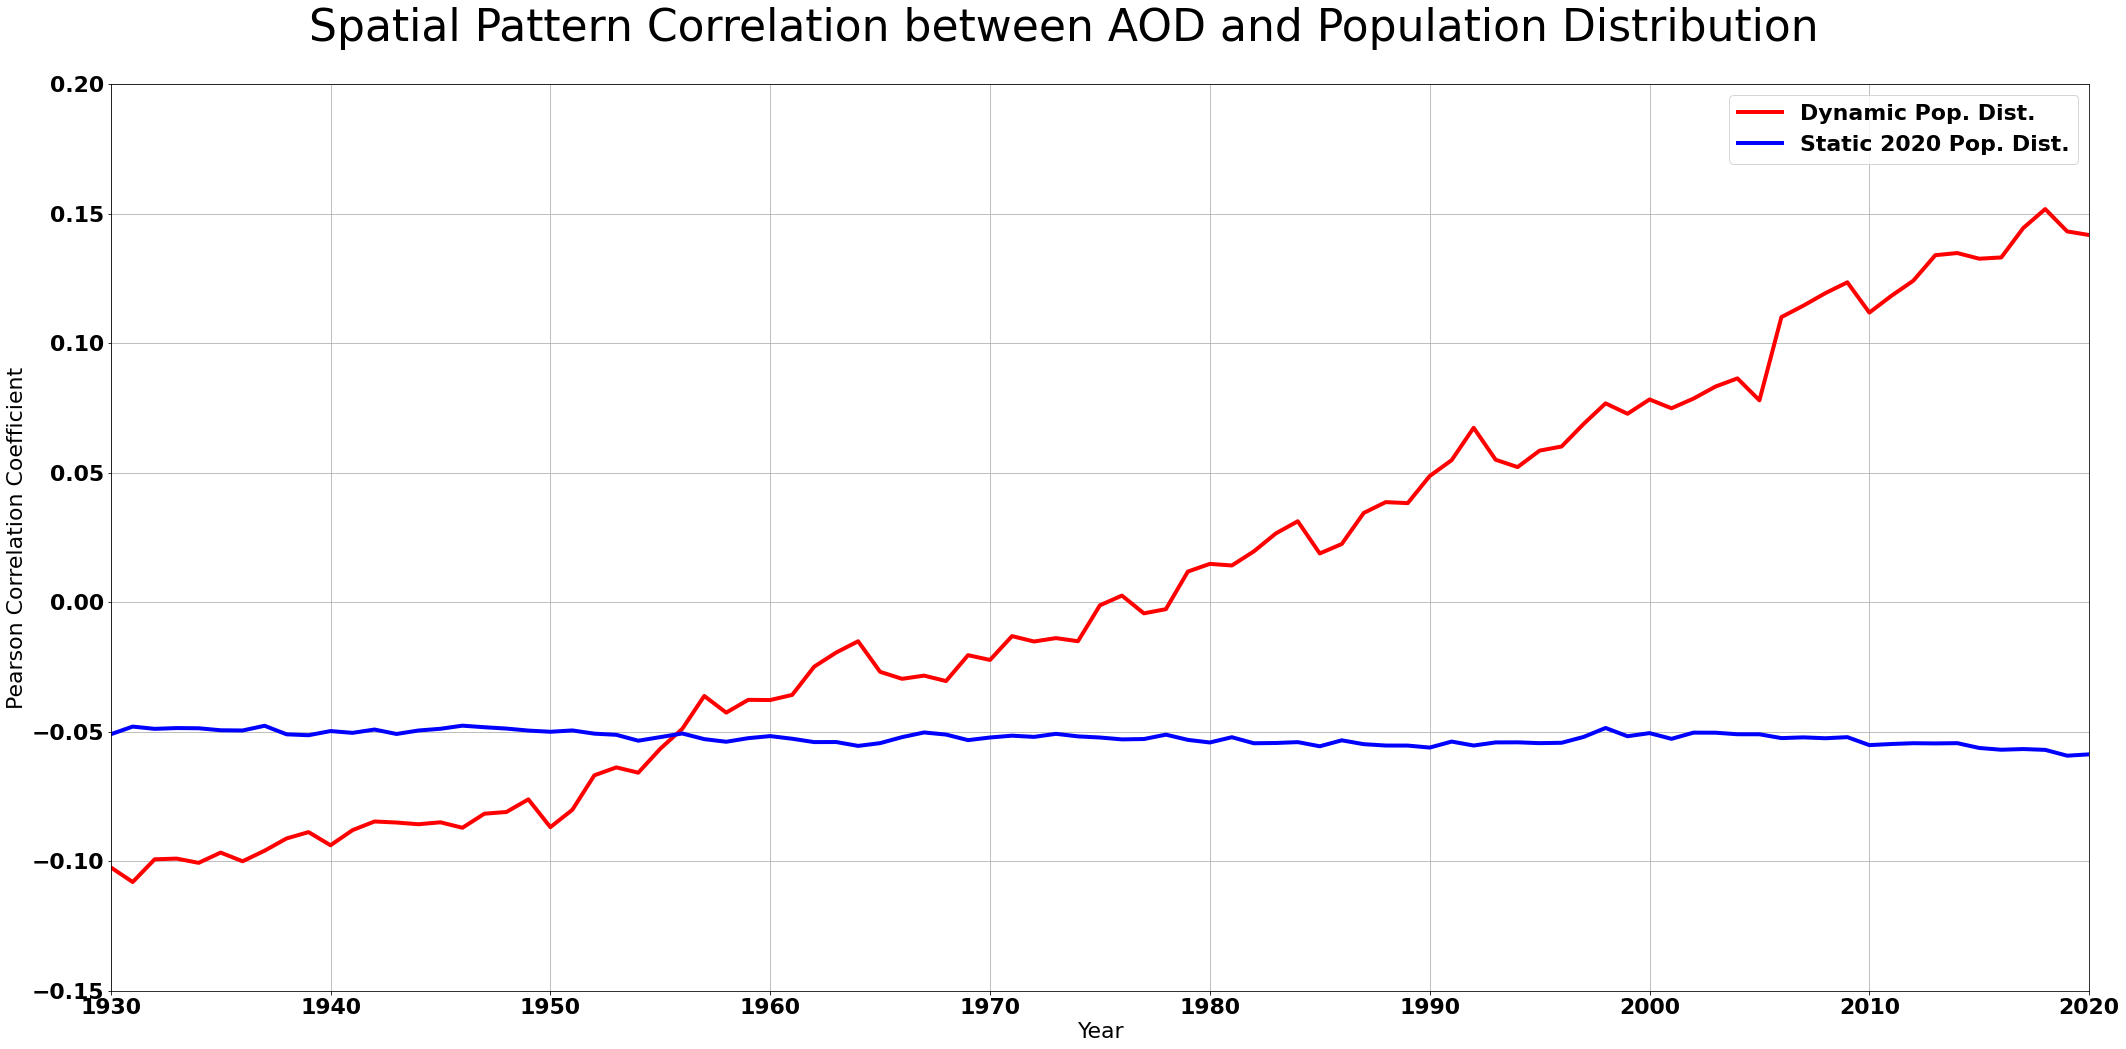

In [295]:
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ax = plt.subplots(1, 1, figsize=(30, 15), facecolor='w')
f.suptitle(f"Spatial Pattern Correlation between AOD and Population Distribution", fontsize=44)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

corr, corr_static = correlate_to_pop(perc_aod)
ax.plot(aer_data.time.values, corr, linewidth=4, label="Dynamic Pop. Dist.", color="red")
ax.plot(aer_data.time.values, corr_static, linewidth=4, label="Static 2020 Pop. Dist.", color="blue")
ax.set_xlim(1930, 2020)
ax.set_ylabel("Pearson Correlation Coefficient")
ax.set_xlabel("Year")
ax.grid()
ax.legend()
f.tight_layout()

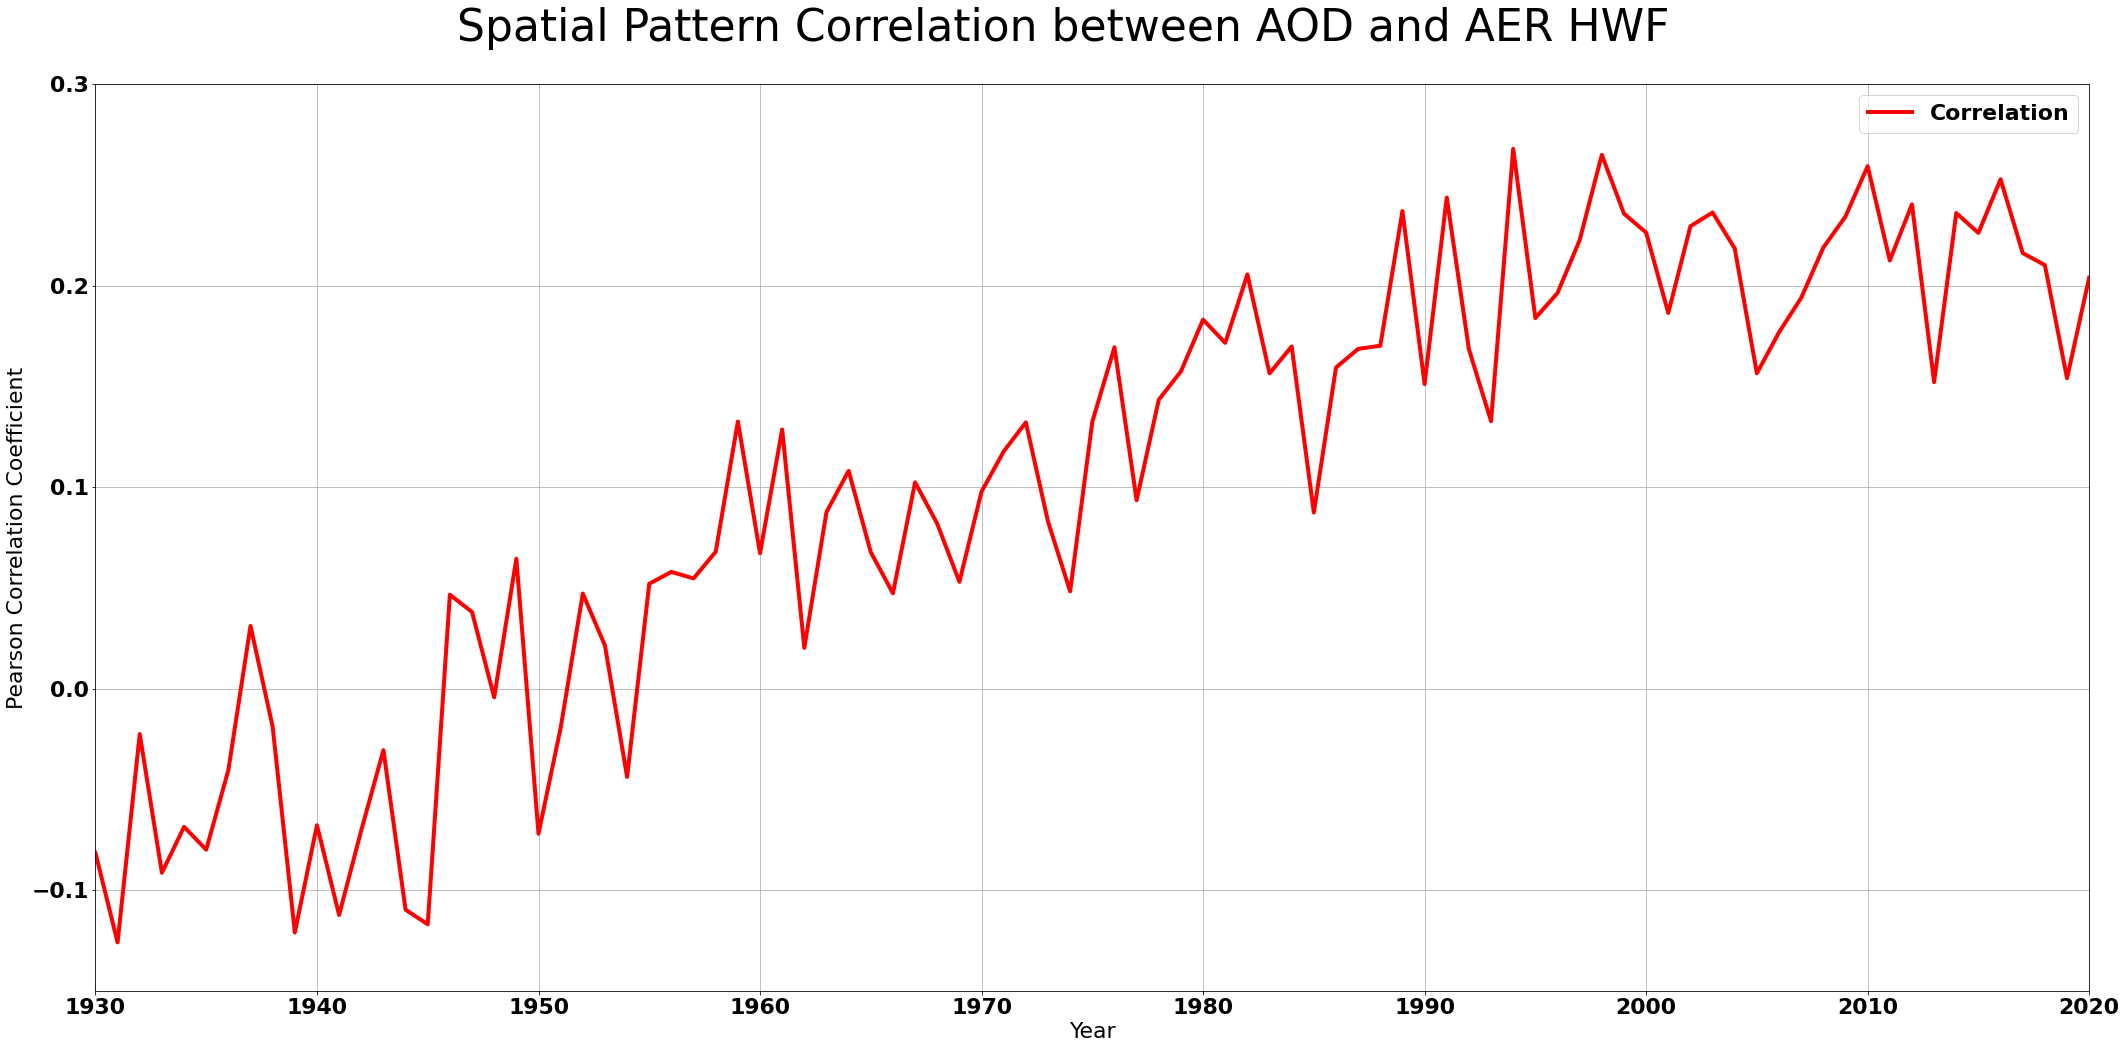

In [299]:
yearly_corr = years*0
for year_i in range(0, years.size):
    a = perc_aer.values[year_i].flatten()[~np.isnan(perc_aer.values[year_i].flatten())]
    b = perc_aod.values[year_i].flatten()[~np.isnan(perc_aod.values[year_i].flatten())]
    yearly_corr[year_i] = np.corrcoef(a, b)[0][1]

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ax = plt.subplots(1, 1, figsize=(30, 15), facecolor='w')
f.suptitle(f"Spatial Pattern Correlation between AOD and AER HWF", fontsize=44)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

corr, corr_static = correlate_to_pop(perc_aod)
ax.plot(aer_data.time.values, yearly_corr, linewidth=4, label="Correlation", color="red")
ax.set_xlim(1930, 2020)
ax.set_ylabel("Pearson Correlation Coefficient")
ax.set_xlabel("Year")
ax.grid()
ax.legend()
f.tight_layout()